In [1]:
# # Make evaluation plots for FFPE SNVF results

library(io)
library(precrec)
library(jsonlite)
library(argparser)
library(tidyverse)
library(glue)
library(patchwork)
library(grid)

library(hrbrthemes)
library(viridis)


Loading required package: filenamer

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: viridisLite



In [2]:

main.outdir <- "../../evaluations/vcf_pass-orient-pos-sb_ad_filtered"
ffpe_snvf.dir <- "../../ffpe-snvf/vcf_pass-orient-pos-sb_ad_filtered"
vcf.dir <- "../../data/vcf_pass-orient-pos-sb_ad_filtered"


In [3]:

add_id <- function(d) {
	d$snv <- paste(d$chrom, d$pos, d$ref, d$alt, sep="_")
	d
}

# label this properly
annotate_truth <- function(d, positives) {
	d$truth <- d$snv %in% positives$snv;
	d
}

# Create a filter function for C>T and G>A mutations
ct_only <- function(df) {
  df[(df$ref == "C" & df$alt == "T") | (df$ref == "G" & df$alt == "A"), ]
}

get_auc <- function(m, ct) {
	d <- auc(m);
	d$aucs[d$curvetypes == ct]
}

auc_title <- function(m, ct) {
	x <- get_auc(m, ct);
	if (ct == "ROC") {
		sprintf("AUROC: %.3f", x)
	}
	else if (ct == "PRC") {
		sprintf("AUPRC: %.3f", x)
	}
	else {
		sprintf("AUC: %.3f", x)
	}
}

adaptive_fdr_cut <- function(q, fp.cut) {
	n <- length(q);
	# adaptive threshold chosen to expect less than one false positive
	idx <- order(q);
	under <- which((1:n) * q[idx] < fp.cut);
	if (length(under) > 0) {
		top <- under[length(under)];
		pred <- logical(n);
		# select the top significant results
		pred[idx[1:top]] <- TRUE;
		pred
	} else {
		# none passes
		rep(FALSE, n)
	}
}

fdr_cut_pred <- function(df, score, fp.cut=0.5) {
	
    df.ct <- df |> filter(complete.cases(.data[[score]]))
    df.nct <- df |> filter(!complete.cases(.data[[score]])) |> mutate(score = NA, q = NA, pred = TRUE)

    df.ct.q <- df.ct |>
        mutate(
            score = ifelse(.data[[score]] == 0, .Machine$double.eps, .data[[score]]),
            q = p.adjust(score, "BH"),
			## TRUE being real muatation and FALSE being artifacts
            pred = ifelse(adaptive_fdr_cut(q, fp.cut), TRUE, FALSE)
        )

    rbind(df.ct.q, df.nct) |>
		arrange(chrom, pos)
}

calc.eval.metrics <- function(df, pred_col = "pred", truth_col = "truth"){

	TP <- df |> filter((.data[[pred_col]]) & (.data[[truth_col]])) |> count() |> pull()
	FP <- df |> filter((.data[[pred_col]]) & !(.data[[truth_col]])) |> count() |> pull()
	FN <- df |> filter(!(.data[[pred_col]]) & (.data[[truth_col]])) |> count() |> pull()
	TN <- df |> filter(!(.data[[pred_col]]) & !(.data[[truth_col]])) |> count() |> pull()

	precision <- TP/(TP + FP)
	recall <- TP/(TP + FN)
	tpr <- recall
	fpr <- FP/(FP + TN)

	list(
		precision = precision,
		recall = recall,
		tp_rate = tpr,
		fp_rate = fpr
	)
}


make.multimodel.eval.object <- function(scores_labels_df, score_columns = c("FOBP", "VAFF", "SOB", "msec"), names = c("mobsnvf", "vafsnvf", "sobdetector", "microsec")) {
	all.model.scores <- do.call(join_scores, scores_labels_df[score_columns])
	all.model.labels <- do.call(join_labels, replicate(length(score_columns), scores_labels_df$truth, simplify = FALSE))
	all.model.names <- names

	evalmod(mmdata(all.model.scores, all.model.labels, all.model.names))
}

make.plot.auc.text <- function(multi.model.eval.object, model.names = c("mobsnvf", "vafsnvf", "sobdetector", "microsec")) {
	
	# Get AUCs to include in plot
	all.model.aucs <- auc(multi.model.eval.object)
	
	# Extract AUROC and AUPRC for each model in model.names
	auroc <- sapply(model.names, function(m) {
		all.model.aucs |> filter(modnames == m & curvetypes == "ROC") |> pull(aucs)
	})
	auprc <- sapply(model.names, function(m) {
		all.model.aucs |> filter(modnames == m & curvetypes == "PRC") |> pull(aucs)
	})

	# Dynamically build AUROC and AUPRC text lines for each model
	auroc_lines <- paste0(model.names, "=", round(auroc[model.names], 3))
	auprc_lines <- paste0(model.names, "=", round(auprc[model.names], 3))

	# Make AUCROC and AUPRC texts to include in the plots
	auc_text <- glue(
		"\n\nAUROC: \n{paste(auroc_lines, collapse = '\n')} \n\nAUPRC: \n{paste(auprc_lines, collapse = '\n')}"
	)

	# Make plot text
	auc_grob <- textGrob(
		auc_text,
		x = 0, y = 1, just = c("left", "top"),
		gp = grid::gpar(fontsize = 8, fontfamily = "mono")
	)

	list(
		text = auc_text,
		text.plot.object = auc_grob
	)
}



make.roc.prc.plot <- function(roc.plot, prc.plot, auc_grob, snv_count = NULL, subtitle = NULL, caption = NULL) {
	
	roc.plot <- roc.plot + ggtitle("ROC")
	prc.plot <- prc.plot + ggtitle("PRC")

	# Compose subtitle based on available info

	if (!is.null(subtitle)) {
		subtitle <- subtitle
	}

	# Compose caption if SNV count is present
	if (!is.null(snv_count)) {
		caption <- glue("Only C>T SNVs Evaluated \nC>T SNV count: {snv_count}")
	}

	# Compose the plot
	combined_plot <- (roc.plot | prc.plot | wrap_elements(auc_grob)) +
		plot_annotation(
			title = 'FFPE SNVF Evaluation',
			subtitle = subtitle,
			caption = caption
		) +
		plot_layout(widths = c(1, 1, 0.6), guides = "collect") &
		theme(
			plot.title = element_text(hjust = 0.5, face = "bold", size = 16, margin = margin(t = 10, b = 10)),
			plot.subtitle = element_text(hjust = 0.5),
			plot.caption = element_text(hjust = 0),
			legend.position = "bottom",
			axis.title.x = element_text(size = 10),
            axis.title.y = element_text(size = 10)
		)

	return(combined_plot)
}


In [4]:
lookup_table <- read.delim("../../annot/sample-info_matched-ff-ffpe_on-pat-id-sample-type.tsv")

n <- c(1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13)
cutoffs <- 5 * 10^(-n) |> sort(decreasing = TRUE)

standard_chromosomes <- paste0("chr", c(1:22, "X", "Y"))

ffpe_vcfs <- lookup_table |>
	filter(sample_type == "Meta") |>
	filter(preservation == "FFPE")

all.samples.all.models.scores.labels <- data.frame()
all.sample.summary <- data.frame()


In [19]:

for (i in seq_len(dim(ffpe_vcfs)[1])) {

    alias <- ffpe_vcfs[i, "sample_alias"]
	run_accession <- ffpe_vcfs[i, "run_accession"]
	sample_name = glue("{alias}_{run_accession}")
	variant_caller <- "MuTect2"
	
    patient_id <- ffpe_vcfs[i, "inferred_id"]
	stage <- ffpe_vcfs[i, "sample_type"]
	preservation <- ffpe_vcfs[i, "preservation"]
	
	# skip <- c("Pat09", "Pat13")
	# if (patient_id %in% skip) next

	out_dir <- glue("{main.outdir}/roc-prc-plots/{sample_name}/")
	dir.create(out_dir, recursive = TRUE, showWarnings = FALSE)
	
	

	truth_annot <- lookup_table |> 
		filter(inferred_id == patient_id) |>
		filter(sample_type == stage) |>
		filter(preservation == "Frozen")

	truth_sample_name <- glue("{truth_annot$sample_alias}_{truth_annot$run_accession}")
	
    # truths <- qread(glue("{vcf.dir}/{truth_sample_name}/{truth_sample_name}.vcf")) |> select(chrom, pos, ref, alt) |> add_id()

	truths <- read.delim(glue("{vcf.dir}/{truth_sample_name}/{truth_sample_name}.vcf"), comment.char = "#", header = FALSE) |> 
		select(V1, V2, V4, V5) |> 
		rename(chrom = V1, pos = V2, ref = V4, alt = V5) |>
		add_id()
	
	## Read and add id (CHROM_POS_REF_ALT)
	mobsnvf <- read.delim(glue("{ffpe_snvf.dir}/mobsnvf/{sample_name}/{sample_name}.mobsnvf.snv")) |> add_id()
	
	vafsnvf <- read.delim(glue("{ffpe_snvf.dir}/vafsnvf/{sample_name}/{sample_name}.vafsnvf.snv")) |> add_id()
	sobdetector <- read.delim(glue("{ffpe_snvf.dir}/sobdetector/{sample_name}/{sample_name}.sobdetector.snv")) |> add_id() |>
		drop_na(artiStatus) |> 
		mutate(SOB = as.numeric(SOB)) |> 
		mutate(SOB = if_else(is.nan(SOB), 0, SOB))

	gatk.obmm <- read.delim(glue("{vcf.dir}/{sample_name}/{sample_name}.vcf"), comment.char = "#", header = FALSE) |> 
		select(V1, V2, V4, V5, V7) |> 
		rename(chrom = V1, pos = V2, ref = V4, alt = V5, filter = V7) |>
		add_id() |>
		mutate(obmm = if_else(str_detect(filter, "orientation"), 0, 1))

	# Higher score is signifies real mutation : VAFSNVF
    # Lower score signifies real mutation:  MOBSNVF, SOBDetector
	# We flip scores for MOBSNVF and SOBDetector to make higher score signify a real muatation

	microsec.exists <- file.exists(glue("{ffpe_snvf.dir}/microsec/outputs/{sample_name}/{sample_name}.microsec.tsv"))
	if (microsec.exists) {
		microsec <- read.delim(glue("{ffpe_snvf.dir}/microsec/outputs/{sample_name}/{sample_name}.microsec.tsv"))|> 
			mutate(msec = ifelse((msec_filter_all == "Artifact suspicious"), 0, 1)) |>
			rename(chrom = "Chr", pos = "Pos", ref = "Ref", alt = "Alt") |>
			add_id()
	}
	
	all.models.scores.labels <- mobsnvf |>
		filter(chrom %in% standard_chromosomes) |>
		select(chrom, pos, ref, alt, snv, FOBP) |>
		drop_na() |>
		left_join(select(vafsnvf, snv, VAFF), by="snv") |>
		left_join(select(sobdetector, snv, SOB), by="snv") |>
		left_join(select(gatk.obmm, snv, obmm), by="snv") |>
		add_id()
		# |>
		# drop_na()
		
	if (microsec.exists) {
		all.models.scores.labels <- all.models.scores.labels |>
			left_join(select(microsec, snv, msec), by="snv")
	} else {
		all.models.scores.labels <- all.models.scores.labels |>
			mutate(msec = NA, msec = as.numeric(msec))
	}

	all.models.scores.labels <- all.models.scores.labels |>
			mutate(FOBP = -FOBP) |>
			mutate(SOB = -abs(SOB)) |>
			annotate_truth(truths)


	stdout <- glue("\n\n{i}. Making ROC and PRC plots for:
FFPE Sample: {sample_name}
Frozen/Truth Sample: {truth_sample_name}
SNVs Evaluated: {dim(all.models.scores.labels)[1]}
truth_n_real : {dim(filter(all.models.scores.labels, truth))[1]}
truth_n_artifacts : {dim(filter(all.models.scores.labels, !truth))[1]}
\n")
	print(stdout)

	summary <- data.frame(
		sample_name = sample_name,
		truth_sample_name = truth_sample_name,
		snvs_evaluated = dim(all.models.scores.labels)[1],
		truth_n_real = dim(filter(all.models.scores.labels, truth))[1],
		truth_n_artifacts = dim(filter(all.models.scores.labels, !truth))[1]
	)

	all.sample.summary <- rbind(all.sample.summary, summary)

	if (dim(filter(all.models.scores.labels, truth))[1] == 0) {
		print(glue("\n{sample_name} could not be evaluated as it contains 0 positive entries for truth\n"))
		next
	}

	all.model.scores <- join_scores(all.models.scores.labels$FOBP, all.models.scores.labels$VAFF, all.models.scores.labels$SOB, all.models.scores.labels$msec, all.models.scores.labels$obmm) # 
	all.model.labels <- join_labels(all.models.scores.labels$truth, all.models.scores.labels$truth, all.models.scores.labels$truth, all.models.scores.labels$truth, all.models.scores.labels$truth) # 
	all.model.names <- c("mobsnvf", "vafsnvf", "sobdetector", "microsec", "gatk_obmm") # 

	all.model.eval <- evalmod(mmdata(all.model.scores, all.model.labels, all.model.names))



	# Get AUCs to include in plot
	all.model.aucs <- auc(all.model.eval)
	
	## AUROC for each model
	auroc.mobsnvf <- all.model.aucs |> filter(modnames == "mobsnvf" & curvetypes == "ROC") |> pull(aucs)
	auroc.vafsnvf <- all.model.aucs |> filter(modnames == "vafsnvf" & curvetypes == "ROC") |> pull(aucs)
	auroc.sobdetector <- all.model.aucs |> filter(modnames == "sobdetector" & curvetypes == "ROC") |> pull(aucs)
	auroc.microsec <- all.model.aucs |> filter(modnames == "microsec" & curvetypes == "ROC") |> pull(aucs)
	auroc.gatk.obmm <- all.model.aucs |> filter(modnames == "gatk_obmm" & curvetypes == "ROC") |> pull(aucs)

	## AUPRC for each model
	auprc.mobsnvf <- all.model.aucs |> filter(modnames == "mobsnvf" & curvetypes == "PRC") |> pull(aucs)
	auprc.vafsnvf <- all.model.aucs |> filter(modnames == "vafsnvf" & curvetypes == "PRC") |> pull(aucs)
	auprc.sobdetector <- all.model.aucs |> filter(modnames == "sobdetector" & curvetypes == "PRC") |> pull(aucs)
	auprc.microsec <- all.model.aucs |> filter(modnames == "microsec" & curvetypes == "PRC") |> pull(aucs)
	auprc.gatk.obmm <- all.model.aucs |> filter(modnames == "gatk_obmm" & curvetypes == "PRC") |> pull(aucs)


	# Make AUCROC and AUPRC texts to include in the plots


	microsec={round(auroc.microsec, 3)}
	auc_text <- glue(
		"
		AUROC:
		mobsnvf={round(auroc.mobsnvf, 3)}
		vafsnvf={round(auroc.vafsnvf, 3)}
		sobdetector={round(auroc.sobdetector, 3)}
		microsec={round(auroc.microsec, 3)}
		gatk-obmm={round(auroc.gatk.obmm, 3)}

		AUPRC:
		mobsnvf={round(auprc.mobsnvf, 3)}
		vafsnvf={round(auprc.vafsnvf, 3)}
		sobdetector={round(auprc.sobdetector, 3)}
		gatk-obmm={round(auprc.gatk.obmm, 3)}"
	)

	# Make plot text
	auc_grob <- textGrob(
			auc_text,
			x = 0, y = 1, just = c("left", "top"),
			gp = grid::gpar(fontsize = 8, fontfamily = "mono")
		)

	# Make the ROC plot
	all.model.roc.plot <- autoplot(all.model.eval, "ROC") +
		ggtitle("ROC") +
		theme(
            plot.title = element_text(size = 12, hjust = 0.5),
            axis.title.x = element_text(size = 10),
            axis.title.y = element_text(size = 10)
        )
	
	# Make the PRC plot
	all.model.prc.plot <- autoplot(all.model.eval, "PRC") +
		ggtitle("PRC") +
		theme(
            plot.title = element_text(size = 12, hjust = 0.5),
            axis.title.x = element_text(size = 10),
            axis.title.y = element_text(size = 10)
        )

	# Join the three together


	caption <- glue("Only C>T SNVs Evaluated \nC>T SNV count: {dim(all.models.scores.labels)[1]} \nVariants Called using {variant_caller}")

	if (!microsec.exists) {
		caption <- glue("{caption}\nMicroSEC not evaluated for this sample")
	}

	all.model.roc.prc.plot <- (all.model.roc.plot | all.model.prc.plot | wrap_elements(auc_grob)) + 
		plot_annotation(
			title = 'FFPE SNVF Evaluation',
			subtitle = glue("Sample: {sample_name}"),
			caption = caption
		) +
		plot_layout(widths = c(1, 1, 0.6), guides = "collect") & 
		theme(
			plot.title = element_text(hjust = 0.5, face = "bold", size = 16, margin = margin(t = 10, b = 10)),
			plot.subtitle = element_text(hjust = 0.5),
			plot.caption = element_text(hjust = 0),
			legend.position = "bottom"
		)

	## Individual Eval
    p.vafsnvf <- with(all.models.scores.labels, evalmod(scores = VAFF, labels = truth))
    p.mobsnvf <- with(all.models.scores.labels, evalmod(scores = FOBP, labels = truth))
	p.sobdetector <- with(all.models.scores.labels, evalmod(scores = SOB, labels = truth))
	p.microsec <- with(all.models.scores.labels, evalmod(scores = msec, labels = truth))
	p.gatk.obmm <- with(all.models.scores.labels, evalmod(scores = obmm, labels = truth))

    res <- list(
			mobsnvf = p.mobsnvf,
			vafsnvf = p.vafsnvf,
			sobdetector = p.sobdetector,
			microsec = p.microsec,
			gatk = p.gatk.obmm,
			all_models = all.model.eval
		)
	
	# For debugging in notebook
	options(repr.plot.width = 7, repr.plot.height = 5)

	# Save plot and res
    qdraw(all.model.roc.prc.plot, glue("{out_dir}/{sample_name}_roc_prc.pdf"), width = 7, height = 5)

	qwrite(res, glue("{out_dir}/{sample_name}_eval_res.rds"))
	qwrite(as.data.frame(all.model.eval), glue("{out_dir}/{sample_name}_eval_res.tsv"))

	qwrite(all.models.scores.labels, glue("{out_dir}/{sample_name}_dataset_labeled.tsv"))

	# Mark the cutoff position for different values of fp-cut
	print(glue("Determining mobsnvf cutoff point across different values of fp-cut:"))
	for (cutoff_value in cutoffs) {
		print(glue("\t{cutoff_value}"))
		mobsnvf.cut.metrics <- all.models.scores.labels |> 
			# filter(chrom %in% standard_chromosomes) |>
			# drop_na() |>
			# ct_only() |>
			select(chrom, pos, ref, alt, snv, truth, FOBP) |>
			mutate(FOBP = -FOBP) |>
			fdr_cut_pred("FOBP", fp.cut = cutoff_value) |>
			# annotate_truth(truths) |>
			calc.eval.metrics()
		
		mobsnvf.cut.roc.plot <- all.model.roc.plot +
			geom_point(aes(x=mobsnvf.cut.metrics$fp_rate , y=mobsnvf.cut.metrics$tp_rate), color="red", shape=4)

		mobsnvf.cut.prc.plot <- all.model.prc.plot + 
			geom_point(aes(x=mobsnvf.cut.metrics$recall , y=mobsnvf.cut.metrics$precision), color="red", shape =4)

		eval.mobsnvf.cut.roc.prc.plot <- (mobsnvf.cut.roc.plot | mobsnvf.cut.prc.plot | wrap_elements(auc_grob)) + 
			plot_annotation(
				title = 'FFPE SNVF Evaluation',
				subtitle = glue("Sample: {sample_name}"),
				caption = glue("fp-cut: {cutoff_value} \nSNV Count: {dim(all.models.scores.labels)[1]} \nVariants called using {variant_caller}")
			) +
			plot_layout(widths = c(1, 1, 0.6), guides = "collect") & 
			theme(
				plot.title = element_text(hjust = 0.5, face = "bold", size = 16, margin = margin(t = 10, b = 10)),
				plot.subtitle = element_text(hjust = 0.5),
				plot.caption = element_text(hjust = 0),
				legend.position = "bottom"
			)

		
		dir.create(glue("{out_dir}/mobsnvf_cutoffs"), recursive = TRUE, showWarnings = FALSE)
		qdraw(eval.mobsnvf.cut.roc.prc.plot, 
			glue("{out_dir}/mobsnvf_cutoffs/{sample_name}_cutoff-{cutoff_value}_roc_prc.pdf"),
			width = 7, height = 5
		)
	}
	print(glue("Done\n"))
	
	all.models.scores.labels <- all.models.scores.labels |> mutate(variant_caller = variant_caller, sample_name = sample_name)
	all.samples.all.models.scores.labels <- rbind(all.samples.all.models.scores.labels, all.models.scores.labels)
	
}



1. Making ROC and PRC plots for:
FFPE Sample: Pat01_Meta_FFPE_ERR791893
Frozen/Truth Sample: Pat01_Meta_Frozen_ERR791883
SNVs Evaluated: 34
truth_n_real : 1
truth_n_artifacts : 33

Determining mobsnvf cutoff point across different values of fp-cut:
	0.5
	0.05
	0.005
	5e-04
	5e-05
	5e-06


Warning message:
“Removed 5005 rows containing missing values or values outside the scale range
(`geom_point()`).”


	5e-07


Warning message:
“Removed 5005 rows containing missing values or values outside the scale range
(`geom_point()`).”


	5e-08


Warning message:
“Removed 5005 rows containing missing values or values outside the scale range
(`geom_point()`).”


	5e-10


Warning message:
“Removed 5005 rows containing missing values or values outside the scale range
(`geom_point()`).”


	5e-12


Warning message:
“Removed 5005 rows containing missing values or values outside the scale range
(`geom_point()`).”


	5e-13


Warning message:
“Removed 5005 rows containing missing values or values outside the scale range
(`geom_point()`).”


Done

2. Making ROC and PRC plots for:
FFPE Sample: Pat03_Meta_FFPE_ERR791895
Frozen/Truth Sample: Pat03_Meta_Frozen_ERR791884
SNVs Evaluated: 49
truth_n_real : 0
truth_n_artifacts : 49

Pat03_Meta_FFPE_ERR791895 could not be evaluated as it contains 0 positive entries for truth

3. Making ROC and PRC plots for:
FFPE Sample: Pat04_Meta_FFPE_ERR791896
Frozen/Truth Sample: Pat04_Meta_Frozen_ERR791891
SNVs Evaluated: 33
truth_n_real : 0
truth_n_artifacts : 33

Pat04_Meta_FFPE_ERR791896 could not be evaluated as it contains 0 positive entries for truth

4. Making ROC and PRC plots for:
FFPE Sample: Pat08_Meta_FFPE_ERR791901
Frozen/Truth Sample: Pat08_Meta_Frozen_ERR791886
SNVs Evaluated: 17
truth_n_real : 0
truth_n_artifacts : 17

Pat08_Meta_FFPE_ERR791901 could not be evaluated as it contains 0 positive entries for truth

5. Making ROC and PRC plots for:
FFPE Sample: Pat09_Meta_FFPE_ERR791902
Frozen/Truth Sample: Pat09_Meta_Frozen_ERR791887
SNVs Evaluated: 38
truth_n_real : 0
truth_n_arti

In [23]:

print(glue("Finished making per sample ROC/PRC plots. Directory: {main.outdir}/roc-prc-plots/\n"))

qwrite(all.sample.summary, glue("{main.outdir}/all_samples-summary.tsv"))
print(glue("Saved summary to: {main.outdir}/all_samples-summary.tsv"))

qwrite(all.samples.all.models.scores.labels, glue("{main.outdir}/all_samples_all_models_scores_labels.tsv"))
print(glue("Saved scores and truth lables of all models to: {main.outdir}/all_samples_all_models_scores_labels.tsv"))

Finished making per sample ROC/PRC plots. Directory: ../../evaluations/vcf_pass-orient-pos-sb_ad_filtered/roc-prc-plots/


Saved summary to: ../../evaluations/vcf_pass-orient-pos-sb_ad_filtered/all_samples-summary.tsv
Saved scores and truth lables of all models to: ../../evaluations/vcf_pass-orient-pos-sb_ad_filtered/all_samples_all_models_scores_labels.tsv


In [24]:
# options(repr.plot.width = 7, repr.plot.height = 5)

eval_df <- all.samples.all.models.scores.labels
all.samples.eval <- make.multimodel.eval.object(eval_df, score_columns = c("FOBP", "VAFF", "SOB", "msec", "obmm"), names = c("mobsnvf", "vafsnvf", "sobdetector", "microsec", "gatk-obmm"))
plot.auc.text <- make.plot.auc.text(all.samples.eval, model.names = c("mobsnvf", "vafsnvf", "sobdetector", "microsec", "gatk-obmm"))$text.plot.object
all.model.roc.plot <- autoplot(all.samples.eval, "ROC")
all.model.prc.plot <- autoplot(all.samples.eval, "PRC")


all.samples.roc.prc.plot <- make.roc.prc.plot(
	all.model.roc.plot, 
	all.model.prc.plot, 
	plot.auc.text, 
	subtitle = glue("All Patients, Metastasis Samples \nVariant Caller: MuTect2"),
	snv_count = dim(eval_df)[1]
)

# all.samples.roc.prc.plot
print(glue("Saved ROC and PRC plots across all samples to {main.outdir}/roc-prc-plots/all_samples_all_roc_prc_plot.pdf\n"))
qdraw(all.samples.roc.prc.plot, glue("{main.outdir}/roc-prc-plots/all_samples_all_roc_prc_plot.pdf"), width = 7, height = 5)



Saved ROC and PRC plots across all samples to ../../evaluations/vcf_pass-orient-pos-sb_ad_filtered/roc-prc-plots/all_samples_all_roc_prc_plot.pdf


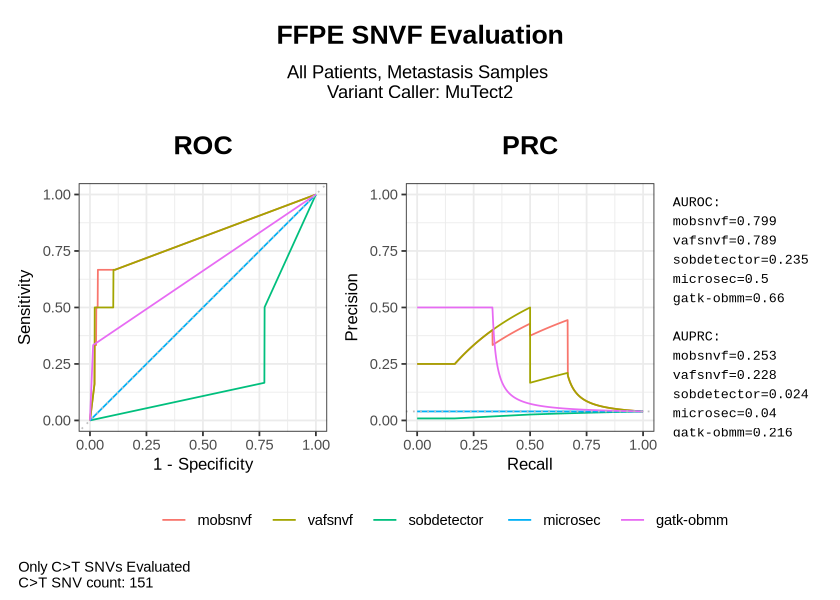

In [25]:
all.samples.roc.prc.plot

In [28]:


## Obtain AUROC and AUPRC from the evaluation results saved previously
eval_res_path <- list.files(glue("{main.outdir}/roc-prc-plots"), pattern = "_eval_res\\.rds", recursive = TRUE, full.names = TRUE)

## Append AUROC and AUPRC for each model to a dataframe
model.aucs <- data.frame()

for (path in eval_res_path) {
	parts <- stringr::str_split_1(path, "/")
	sample_id <- sub("_eval_res.rds", "", parts[6])
	variant_caller <- "MuTect2"

	eval_res <- readRDS(path)
	models <- names(eval_res)

	for (model in models[models != "all_models"]) {
		aucs <- auc(eval_res[[model]])
		auroc <- aucs |> filter(curvetypes == "ROC") |> pull(aucs)
		auprc <- aucs |> filter(curvetypes == "PRC") |> pull(aucs)
		model.aucs <- bind_rows(
			model.aucs,
			data.frame(
				sample_id = sample_id,
				variant_caller = variant_caller,
				model = model,
				auroc = auroc,
				auprc = auprc,
				stringsAsFactors = FALSE
			)
		)
	}
}

## Save the AUCs
write.table(model.aucs, glue("{main.outdir}/aucs.tsv"), sep = "\t", row.names = FALSE)
print(glue("Saved AUCs of each sample at {main.outdir}/aucs.tsv"))



Saved AUCs of each sample at ../../evaluations/vcf_pass-orient-pos-sb_ad_filtered/aucs.tsv


In [29]:


## Find VCFs where mobsnvf performs worse than other models
print(glue("Determining where MOBSNVF performs worse than other models"))
vcfs.mobsnvf.lower.auroc <- model.aucs |>
  group_by(sample_id) |>
  # Summarize mobsnvf AUROC and the max AUROC of the others
  summarize(
    mob_auroc   = auroc[model == "mobsnvf"],
    others_max  = max(auroc[model != "mobsnvf"])
  ) |> filter(mob_auroc < others_max) |>
  pull(sample_id)

lower.mobsnvf.auroc <- model.aucs |> filter(sample_id %in% vcfs.mobsnvf.lower.auroc)
# lower.mobsnvf.auroc

vcfs.mobsnvf.lower.auprc <- model.aucs |>
  group_by(sample_id) |>
  # compute mobsnvf auprc and the min auprc of the others
  summarize(
    mob_auprc   = auprc[model == "mobsnvf"],
    others_max  = max(auprc[model != "mobsnvf"])
  ) |> filter(mob_auprc < others_max) |>
  pull(sample_id)

lower.mobsnvf.auprc <- model.aucs |> filter(sample_id %in% vcfs.mobsnvf.lower.auprc)
# lower.mobsnvf.auprc

print(glue("\tSaving the AUROC and AUPRC for these samples to a table"))


## Save the AUCs of these specific samples to examine later
write.table(lower.mobsnvf.auroc, glue("{main.outdir}/mobsnvf_lower_auroc.tsv"), sep = "\t", row.names = FALSE)
write.table(lower.mobsnvf.auprc, glue("{main.outdir}/mobsnvf_lower_auprc.tsv"), sep = "\t", row.names = FALSE)
print(glue("\t\t- {main.outdir}/mobsnvf_lower_auroc.tsv"))
print(glue("\t\t- {main.outdir}/mobsnvf_lower_auprc.tsv\n"))



Determining where MOBSNVF performs worse than other models
	Saving the AUROC and AUPRC for these samples to a table


		- ../../evaluations/vcf_pass-orient-pos-sb_ad_filtered/mobsnvf_lower_auroc.tsv
- ../../evaluations/vcf_pass-orient-pos-sb_ad_filtered/mobsnvf_lower_auprc.tsv


In [30]:


## Make boxplots
scale = 0.4; w = 14*scale; h = 12*scale
options(repr.plot.width = w, repr.plot.height = h)

### Box plotting function
make_auc_boxplot <- function(
    df,
    auc_type_col,
    model_col = "model",
    scale = 1,
    text_scale = 1,
    width = 14,
    height = 12,
	subtitle = NULL,
    grids = FALSE
){
    # options(repr.plot.width = width * scale, repr.plot.height = height * scale)

    title_insert <- c(
        "auroc" = "Area under Receiver Operating Characteristic Curve",
        "auprc" = "Area under Precision-Recall Curve"
    )

    auc_model_boxplot <- ggplot(df, aes(x = .data[[model_col]], y = .data[[auc_type_col]], fill = .data[[model_col]])) +
        geom_boxplot(width = 0.5, alpha = 0.9) +
        geom_jitter(color = "black", size = 0.4, alpha = 0.7) +
        scale_fill_viridis(discrete = TRUE) +
        theme_ipsum(base_family = "sans") +
        theme(
            legend.position = "none",
            plot.title = element_text(size = 24 * text_scale, margin = margin(b = 10), hjust = 0.5), # Control title size, padding and position
            plot.subtitle = element_text(size = 18 * text_scale, margin = margin(b = 15), hjust = 0.5), # subtitle size, padding 
            axis.title.x = element_text(size = 20 * text_scale, margin = margin(t = 10), hjust = 0.5), # x label, padding 
            axis.title.y = element_text(size = 20 * text_scale, margin = margin(r = 10), hjust = 0.5), # y label, padding 
            axis.text.x = element_text(size = 14 * text_scale, color = "grey30"), # x tick labels
            axis.text.y = element_text(size = 14 * text_scale, color = "grey40"), # y tick labels
            # legend.text = element_text(size = 16 * text_scale), # legend text size
            # legend.title = element_text(size = 18 * text_scale, face = "bold"), # legend title size and properties
            # legend.key.size = unit(1.5, "cm"), # legend keys sizes
            # legend.key.width = unit(1.5, "cm"), # legend keys sizes
            strip.text = element_text(size = 18 * text_scale, hjust = 0.5),
            panel.grid.minor = element_line(color = "grey95", linewidth = 0.5), # minor grids properties
            panel.grid.major = element_line(color = "grey95", linewidth = 0.5), # major grids properties
        ) +
        labs(
            x = "Model", 
            y = toupper(auc_type_col),
            title = unname(title_insert[tolower(auc_type_col)]),
            subtitle= paste0(if (is.null(subtitle)) "" else subtitle)
        )

    if (grids) {
        auc_model_boxplot <- auc_model_boxplot +
            scale_y_continuous(
                breaks = seq(0, 1, by = 0.1), # major y-tick granularity
                minor_breaks = seq(0, 1, by = 0.02) # minor y-tick granularity
            ) + 
            theme(
                panel.grid.minor = element_line(color = "grey90", linewidth = 0.5), # minor grids properties
                panel.grid.major = element_line(color = "grey85", linewidth = 0.5), # major grids properties
            )
    }

    
    return(auc_model_boxplot)
}


In [31]:

### Function to make AUPRC and AUROC plots from multiple variant callers using the make_auc_boxplot function. 
### We only use mutect2 in this particular case case
make_all_auc_boxplots <- function(results, scale = 0.4, text_scale = 0.5, w = 14*scale, h = 12*scale, 
	variant_callers = c("all", "muse", "mutect2", "somaticsniper", "varscan2")
	) {
	subtitles <- c(
		"all" = "All Variant Callers",
		"muse" = "MuSE",
		"mutect2" = "MuTect2",
		"somaticsniper" = "SomaticSniper",
		"varscan2" = "VarScan2"
	)
	auc_types <- c("auroc", "auprc")
	plots <- list()
	for (auc_type in auc_types) {
		plots[[auc_type]] <- list()
		for (caller in variant_callers) {
			if (caller == "all") {
				df <- model.aucs
			} else {
				df <- model.aucs |> filter(variant_caller == caller)
			}
			plots[[auc_type]][[caller]] <- make_auc_boxplot(
				df, auc_type, scale = scale, text_scale = text_scale, subtitle = caller
			)
		}
	}
	return(plots)
}


In [32]:

print(glue("Making AUROC and AUPRC boxplots"))
# Call the plotting function
all_auc_boxplots <- make_all_auc_boxplots(model.aucs, scale = 0.4, text_scale = 0.5, w = w, h = h, variant_callers = c("MuTect2"))

# Set outdir for saving plots
outdir = glue("{main.outdir}/box-plots")
dir.create(outdir, recursive = TRUE, showWarnings = FALSE)

### AUROC
# show(all_auc_boxplots$auroc$MuTect2)

##### Save AUROC plots
qdraw(all_auc_boxplots$auroc$MuTect2, file = glue("{outdir}/auroc_mutect2_boxplot.pdf"), width = w, height = h)

### AUPRC
# show(all_auc_boxplots$auprc$MuTect2)

#### Save AUPRC plots
qdraw(all_auc_boxplots$auprc$MuTect2, file = glue("{outdir}/auprc_mutect2_boxplot.pdf"), width = w, height = h)

print(glue("Done.\nBox-Plots saved to {outdir}/"))



Making AUROC and AUPRC boxplots


Done.
Box-Plots saved to ../../evaluations/vcf_pass-orient-pos-sb_ad_filtered/box-plots/
